# Boosting 이란?

- 여러 개의 약한 Decision Tree를 조합해서 사용하는 Ensemble 기법중 하나이다.
- 즉, 약한 예측 모델들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측모델을 만드는 것이다.

# GBM(Gradient Boosting Machine)

- GBM은 여러 개의 weak learner를 순차적으로 학습,예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 가중치의 업데이트 방법은 **경사 하강법(Gradient Descent)**을 사용한다.

# XGBoost 란?

- XGBoost는 Extreme Gradient Boosting의 약자이다.
- Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost가 대표적인데 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost이다.
- Regression, Classifier 문제를 모두 지원하며, 성능과 자원 효율이 좋아서 인기 있는 알고리즘이다.
<br>
- XGBoost의 장점
  1. GBM 대비 빠른 수행시간 : 병렬 처리로 학습, 분류 속도가 빠르다.
  2. 과적합 규제(Regularization) : 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성을 지닌다.
  3. 분류와 회귀 영역에서 뛰어난 예측 성능을 발휘한다.
    - 즉, CART(Classifier and Regression Tree) 앙상블 모델을 사용한다.
  4. Early Stopping(조기 종료) 기능이 있다.
  5. 다양한 옵션을 제공하며 Customizing이 용이하다.

## 필수 라이브러리

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

# 한글 폰트 설정
mpl.rc('font', family='malgun gothic')
# 유니코드에서 음수 부호 설정
mpl.rc('axes', unicode_minus = False)

# 차트 스타일 지정
sns.set(font='malgun gothic', rc={'axes.unicode_minus':False}, style = 'darkgrid')
plt.rc('figure', figsize=(10, 8))

warnings.filterwarnings('ignore')

# 로지스틱 회귀와 평가지표

## 데이터셋 - 위스콘신 유방암 예측 

In [4]:
!pip install xgboost

In [6]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [7]:
X = cancer.data
y = cancer.target

cancer_df = pd.DataFrame(data = X, columns = cancer.feature_names)
cancer_df['target'] = y
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [8]:
print('data shape : ', X.shape)
print('target shape : ', y.shape)

data shape :  (569, 30)
target shape :  (569,)


In [9]:
print(cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [10]:
# 양성 유방암세트와 음성 유방암세트 개수의 파악
np.unique(cancer.target, return_counts = True)

(array([0, 1]), array([212, 357], dtype=int64))

In [11]:
# 30개의 feature가 뭔지를 확인
for i, feature in enumerate(cancer.feature_names):
    print(f'feature{(i+1)} : ', feature)

feature1 :  mean radius
feature2 :  mean texture
feature3 :  mean perimeter
feature4 :  mean area
feature5 :  mean smoothness
feature6 :  mean compactness
feature7 :  mean concavity
feature8 :  mean concave points
feature9 :  mean symmetry
feature10 :  mean fractal dimension
feature11 :  radius error
feature12 :  texture error
feature13 :  perimeter error
feature14 :  area error
feature15 :  smoothness error
feature16 :  compactness error
feature17 :  concavity error
feature18 :  concave points error
feature19 :  symmetry error
feature20 :  fractal dimension error
feature21 :  worst radius
feature22 :  worst texture
feature23 :  worst perimeter
feature24 :  worst area
feature25 :  worst smoothness
feature26 :  worst compactness
feature27 :  worst concavity
feature28 :  worst concave points
feature29 :  worst symmetry
feature30 :  worst fractal dimension


## standarization(표준화)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(cancer_df.drop('target', axis=1))

## 훈련세트와 테스트세트 분리

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    scaled, cancer_df['target'], test_size=0.2, random_state=156)

### 로지스틱 회귀 모델 학습

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [15]:
# 훈련 모델을 이용하여 5개의 샘플 예측
print(lr.predict(X_train[:5]))

[0 1 1 1 1]


- 악성 종양(malignant) 이 0값으로 1개, 양성종양(benign)이 1값으로 4개 예측

In [16]:
# 예측 확률
print(lr.predict_proba(X_train[:5]))

[[9.90703488e-01 9.29651217e-03]
 [3.95649332e-02 9.60435067e-01]
 [6.71031350e-06 9.99993290e-01]
 [1.61627147e-04 9.99838373e-01]
 [8.73555079e-02 9.12644492e-01]]


In [17]:
# classes_ 속성
print(lr.classes_)

[0 1]


In [18]:
# 로지스틱 회귀가 학습한 계수(기울기와 절편) 추출
print(lr.coef_, lr.intercept_)

[[-0.4721854  -0.38258173 -0.44454406 -0.54316124 -0.14319742  0.72706363
  -0.70746211 -0.96418695 -0.07905176  0.27001329 -1.19658305  0.19765208
  -0.5890956  -0.95010481 -0.31150744  0.75959144  0.14533365 -0.32546344
   0.33243796  0.4394735  -0.86822466 -1.27824666 -0.65146591 -0.90866007
  -0.44631307  0.16705142 -0.8564404  -0.83122684 -1.0734741  -0.54801513]] [0.21706473]


In [19]:
# 예측한 5개의 z값 출력
decisions = lr.decision_function(X_train[:5])
print(decisions)

[-4.66877599  3.18944318 11.91185818  8.7300568   2.34636033]


In [20]:
from scipy.special import expit
print(expit(decisions))

[0.00929651 0.96043507 0.99999329 0.99983837 0.91264449]


In [21]:
# 예측하기
predict = lr.predict(X_test)

### 평가지표
1. 회귀(regression) : MAE, MSE, RMSE, SSE..
2. 분류(Classification) : 정확도, 정밀도, 재현율(민감도), F1 스코어, ROC 커브
3. 클러스터링(Clustering) : DBI, 엘보우 메서드, 실루엣계수

In [22]:
# 정확도(Accuracy) : 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표
# 이진 분류일 경우 데이터에 따라(불균형한 데이터 세트) 모델의 성능이 왜곡될 수 있다.
# 정확도 = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수

from sklearn.metrics import accuracy_score
accuracy_score(y_test, predict)

0.9736842105263158

### 혼돈 행렬(Confision Matrix, 오차 행렬)

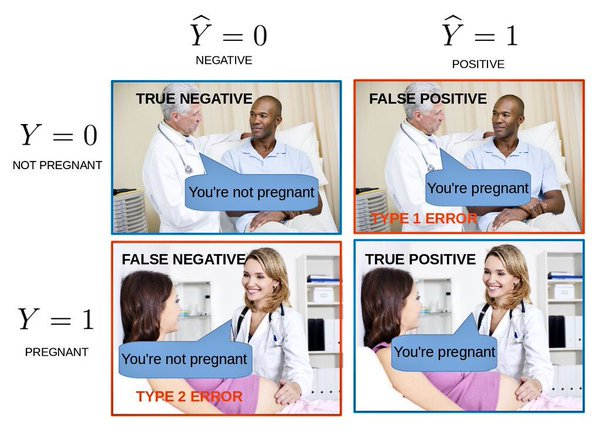

In [23]:
from IPython.display import Image
Image('https://skappal7.files.wordpress.com/2018/08/confusion-matrix.jpg', width=600)

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predict)
cm

array([[35,  2],
       [ 1, 76]], dtype=int64)

Text(64.5, 0.5, 'Actual')

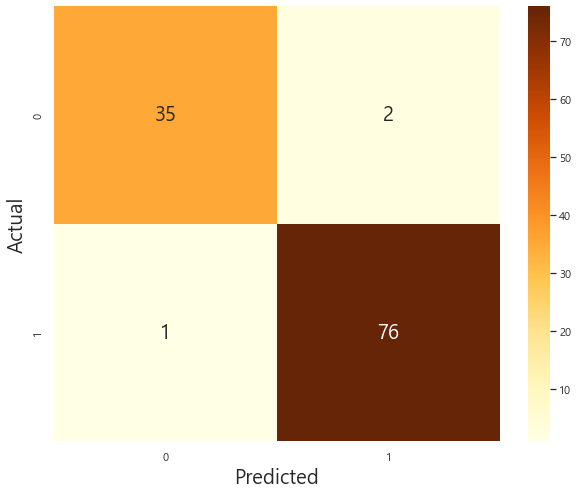

In [25]:
# 혼돈 행렬 시각화
sns.heatmap(cm, annot=True, annot_kws={'size':20}, cmap='YlOrBr')
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)

In [26]:
TN, FP, FN, TP = cm.ravel()

#### 정밀도(Precision)
- Positive로 예측한 전체 건수에서 옳게 예측한 건수의 비율

In [27]:
precision = TP / (FP + TP)
precision

0.9743589743589743

In [28]:
from sklearn.metrics import precision_score
precision_score(y_test, predict)

0.9743589743589743

#### 재현율(Recall), 민감도
- 실제 Positive인 전체 건수에서 옳게 예측한 건수의 비율
- TPR(True Positive Rate)

In [29]:
recall = TP / (FN + TP)
recall

0.987012987012987

In [30]:
from sklearn.metrics import recall_score
recall_score(y_test, predict)

0.987012987012987

#### F1 Score
- 재현율과 정밀도의 균을 나타내는 수치

In [31]:
f1 = 2 * (precision * recall) / (precision + recall)
f1

0.9806451612903225

In [32]:
from sklearn.metrics import f1_score
f1_score(y_test, predict)

0.9806451612903225

# XGBoost 모델 학습

In [33]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

## 위스콘신 유방암 예측

In [35]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
cancer_df["target"] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [36]:
print(dataset.target_names)
print(cancer_df.target.value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_label, test_size=0.2, random_state=156)

dtrain = xgb.DMatrix(data = X_train, label = y_train)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [38]:
params = {
    "max_depth": 3, 
    "eta": 0.1, 
    "objective": "binary:logistic", 
    "eval_metric": "logloss"
    # "early_stoppings": 100 
}

num_rounds = 400 # 부스팅 반복 횟수

### XGB 학습

In [39]:
# evals 파라미터에 train, test 셋을 명기하면 평가를 진행하면서 조기 중단을 적용 할 수 있다.
wlist = [(dtrain, "train"), (dtest, "eval")]

# 모델 학습: 사이킷런과 달리 train() 함수에 파라미터를 전달한다.
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds,
                      evals = wlist)

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35415	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	train-logloss:0.11729	eval-logloss:0.16766
[20]	train-logloss:0.10969	eval-logloss:0.15820
[2

[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08695
[177]	train-logloss:0.00695	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:0.00687	eval-logloss:0.08683
[183]	train-logloss:0.00685	eval-logloss:0.08658
[184]	train-logloss:0.00683	eval-logloss:0.08659
[185]	train-logloss:0.00681	eval-logloss:0.08661
[186]	train-logloss:0.00680	eval-logloss:0.08637
[187]	train-logloss:0.00678	eval-logloss:0.08637
[188]	train-logloss:0.00676	eval-logloss:0.08630
[189]	train-logloss:0.00675	eval-logloss:0.08610
[190]	train-logloss:

[338]	train-logloss:0.00528	eval-logloss:0.08583
[339]	train-logloss:0.00528	eval-logloss:0.08591
[340]	train-logloss:0.00527	eval-logloss:0.08583
[341]	train-logloss:0.00527	eval-logloss:0.08573
[342]	train-logloss:0.00526	eval-logloss:0.08568
[343]	train-logloss:0.00525	eval-logloss:0.08572
[344]	train-logloss:0.00525	eval-logloss:0.08580
[345]	train-logloss:0.00524	eval-logloss:0.08582
[346]	train-logloss:0.00524	eval-logloss:0.08572
[347]	train-logloss:0.00523	eval-logloss:0.08579
[348]	train-logloss:0.00523	eval-logloss:0.08584
[349]	train-logloss:0.00522	eval-logloss:0.08573
[350]	train-logloss:0.00522	eval-logloss:0.08566
[351]	train-logloss:0.00521	eval-logloss:0.08573
[352]	train-logloss:0.00521	eval-logloss:0.08581
[353]	train-logloss:0.00520	eval-logloss:0.08571
[354]	train-logloss:0.00519	eval-logloss:0.08566
[355]	train-logloss:0.00519	eval-logloss:0.08570
[356]	train-logloss:0.00518	eval-logloss:0.08563
[357]	train-logloss:0.00518	eval-logloss:0.08553
[358]	train-logloss:

### XGB 예측

In [40]:
# 예측 확률
pred_probs = xgb_model.predict(dtest)
print("predict() 수행 결과값 10개만 표시")
print(np.round(pred_probs[:10], 3))

# 예측 분류
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print("예측 분류 10개만 표시")
print(f"{preds[:10]}")

predict() 수행 결과값 10개만 표시
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측 분류 10개만 표시
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


### XGB 평가

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)
   
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

In [42]:
get_clf_eval(y_test, pred = preds, pred_proba_po = pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


#### XGB 피처별 중요도

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


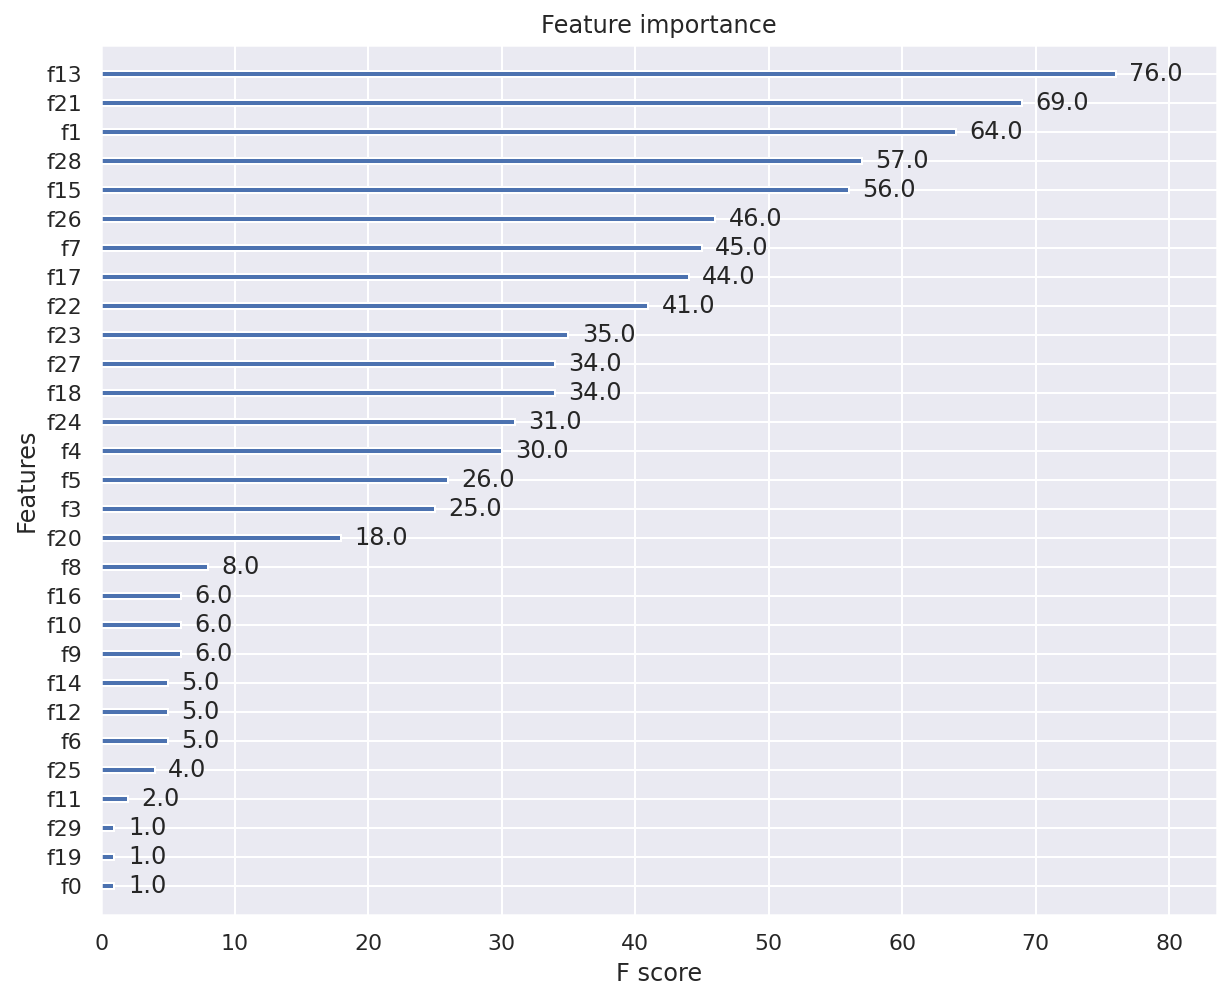

In [43]:
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()

#### XGB 시각화

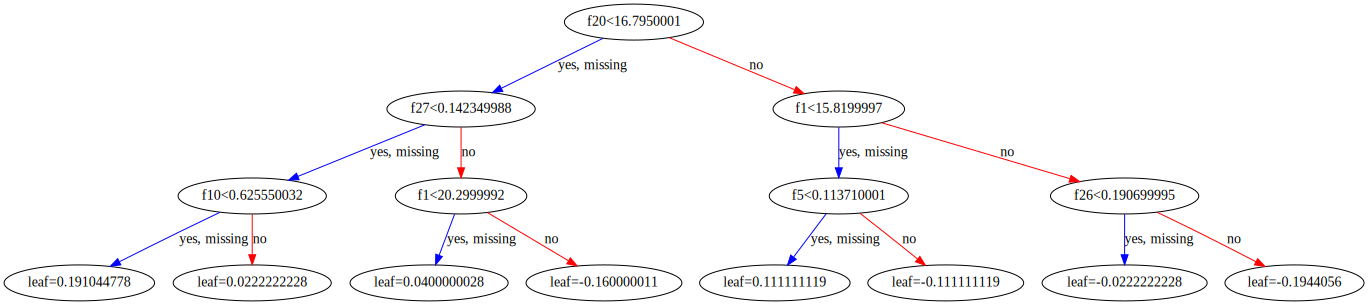

In [44]:
from xgboost import to_graphviz
import graphviz

to_graphviz(xgb_model)

#### XGB 교차검증

In [45]:
xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=3, metrics="logloss")

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.610037,0.000064,0.617448,0.004961
1,0.541817,0.000203,0.555140,0.008989
2,0.483716,0.000955,0.503529,0.012238
3,0.434676,0.001311,0.459869,0.015795
4,0.392310,0.001686,0.423058,0.016788
5,0.355129,0.001391,0.391187,0.019785
6,0.322530,0.001908,0.361119,0.019378
7,0.294159,0.001618,0.337139,0.021086
8,0.269083,0.002068,0.314903,0.019971
9,0.246208,0.001940,0.295012,0.019237


## 위스콘신 유방암 예측

In [46]:
dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
cancer_df["target"] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### XGB 학습 / 예측 / 평가

In [47]:
from xgboost import XGBClassifier

# 파이썬 래퍼와 동일한 하이퍼 파라미터 수치
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth = 3)
xgb_wrapper.fit(X_train, y_train)

w_preds = xgb_wrapper.predict(X_test)
w_pred_probs = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred = w_preds, pred_proba_po = w_pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


### XGB 조기 중단

In [48]:
from xgboost import XGBClassifier

# 객체 생성
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate = 0.1, max_depth = 3)

# eval_set
evals = [ (X_test, y_test) ]

# 학습 (조기 중단 지정)
xgb_wrapper.fit(X_train, y_train,
                # 조기 중단 파라미터
                early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, 
                verbose=True)

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

- XGBRegressor 하이퍼파라미터
  1. 일반 파라미터 : 부스팅을 수행할 때 트리를 사용할지, 선형 모델을 사용할지 등을 고려
    - booster[기본값 = gbtree] : 어떤 부스터 구조를 쓸지 결정
      - 의사결정기반모형(gbtree), 선형모형(gblinear), dart 가 있다.
    - n_jobs : XGBoost를 실행하는 데 사용되는 병렬 스레드 수   
    <br><br>
  2. 부스터 파라미터 : 선택한 부스터에 따라서 적용할 수 있는 파라미터가 다르다
    - learning_rate[기본값=0.3] : 높을수록 과적합하기 쉽다.
    - n_estimators[기본값 = 100] : 생성할 weak learner의 수, learning_rate가 낮을 때 높여야 과적합이 방지된다.
    - max_depth[기본값 = 6] : 트리의 maximun depth값, 적절한 값이 제시되어야 하고 보통 3-10 사이 값이 적용되며, max_depth가 높을수록 모델의 복잡도가 커져 과적합되기 슆다.
    - min_child_weight[기본값 = 1] : 관측치에 대한 가충치 합의 최소를 말하며 값이 높을수록 과적합이 방지된다.
    - gamma[기본값 = 0] : 리프노트의 추가분할을 결정할 최소손실 감소값, 해당 값보다 손실이 크게 감소할 때 분리한다.   
  <br><br>    
  3. 학습 과정 파라미터 : 학습 시나리오를 결정한다. 

In [49]:
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_probs = xgb_wrapper.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred = ws100_preds, pred_proba_po = ws100_pred_probs)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9954


### XGB 피처별 중요도

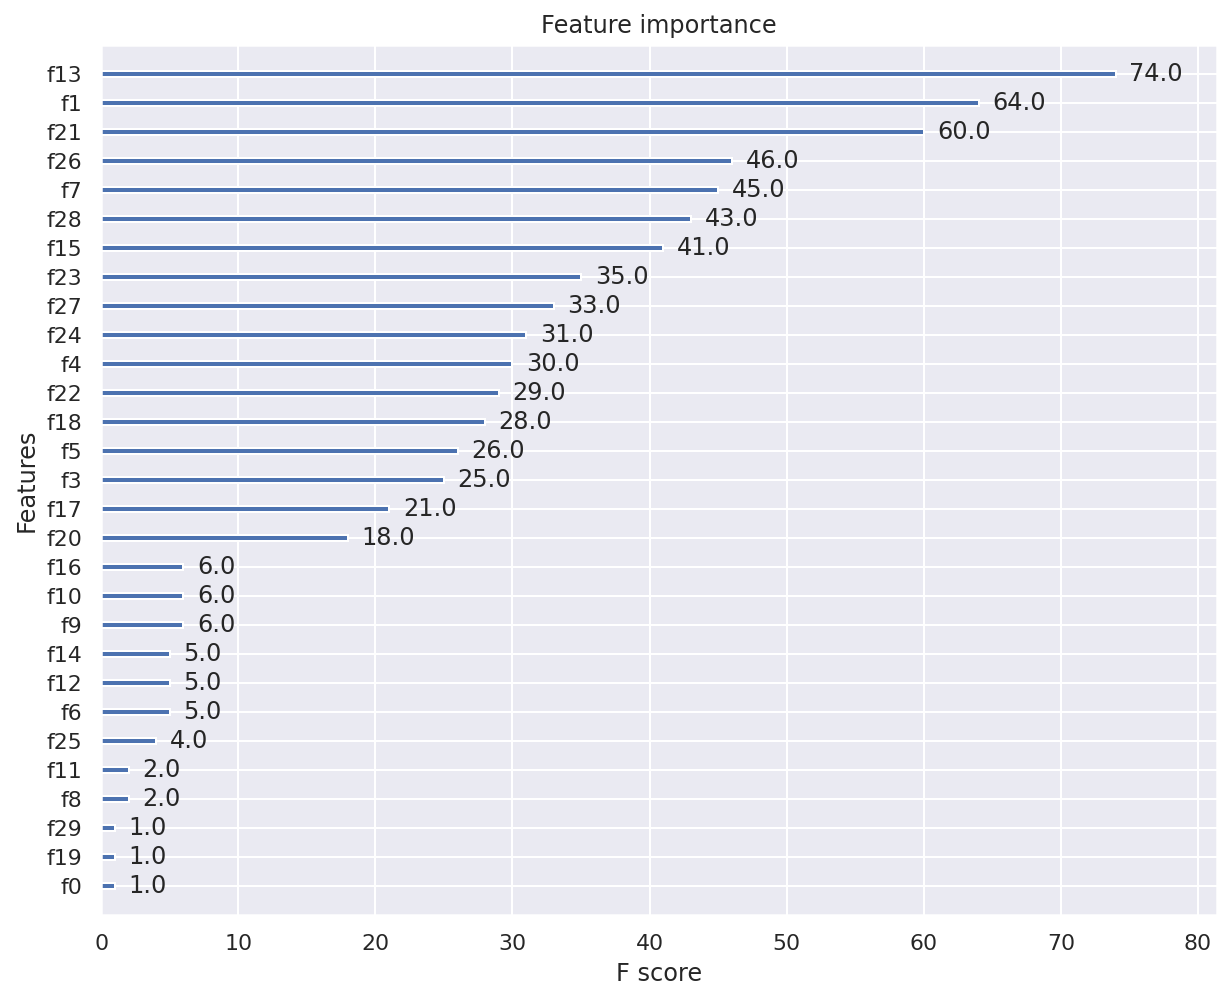

In [50]:
from xgboost import plot_importance

plot_importance(xgb_wrapper)
plt.show()

- **민감하게 조정해야 하는 것**
  - booster 모양
  - eval_metric(평가함수) / objective(목적함수)
  - eta 
  - L1 form (L1 레귤러라이제이션 폼이 L2보다 아웃라이어에 민감하다.)
  - L2 form
 <br><br> 
- **과적합 방지를 위해 조정해야 하는 것**
  - learning rate 낮추기 → n_estimators은 높여야함
  - max_depth 낮추기
  - min_child_weight 높이기
  - gamma 높이기
  - subsample, colsample_bytree 낮추기

# LightGBM

1. LightGBM 장단점
  - XGB보다도 학습에 걸리는 시간이 훨씬 적으며 메모리 사용량도 상대적으로 적다.
  - 카테고리형 피처를 자동 변환하고, 예측 성능 역시 큰 차이가 없다.
  - 데이터의 갯수가 적을 경우 과적합이 발생하기 쉽다.
  - 적은 데이터의 갯수에 대한 기준은 애매하지만 LightGBM의 공식 문서에서 10,000건 이하라고 기술하였다.
<br><br>
2. 트리 기반 알고리즘 특징
  - 기존의 대부분 트리 기반 알고리즘은 트리의 깊이를 효과적으로 줄이기 위한 균형 트리 분할(Level Wise) 방식을 사용한다.
  - 최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 깊이가 최소화 되며 오버피팅에 보다 강한 구조를 가진다.
  - 하지만 균형을 맞추기 위한 시간이 오래 걸리는 단점이 있다.
<br><br>
3. LightGBM 특징
  - LightGBM은 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할(Leaf Wise) 방식을 사용한다.
  - 트리의 균형을 맞추지 않고 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하여 깊이가 증가하고 비대칭적인 트리를 생성한다.
  - 이렇게 생성된 트리는 학습을 반복할수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화 할 수 있다는 것이 LightGBM 구현사상이다.